## 라이브러리 및 데이터 호출

In [1]:
# 라이브러리 호출 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import scikit_posthocs as sp
from scipy import stats
from sklearn.linear_model import LinearRegression

# plt 폰트 설정 
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [2]:
# 데이터 호출
data = pd.read_csv("C:/Users/dlwlg/Desktop/final/상권지수/피처엔지니어링일단다한통합데이터.csv")

## 포화도 라벨링 기준 정하기
**경쟁강도 :: 상권 점포수 / 행정동 점포수**  
매출경쟁도 :: 상권 당월 매출 / 해당 행정동 당월 매출  
상권밀집도 :: 상권 점포수 / 상권 면적

포화지수 = (경쟁강도 * 0.4) + (매출경쟁도 * 0.4) + (상권밀집도 * 0.2)

In [3]:
# 포화도 기준용 데이터프레임 생성 
data_label = data[['기준_년분기_코드','상권_코드_명','유사_업종_점포_수','행정동_코드_명','자치구_코드_명']]

In [4]:
# 업종 상관 없이 상권 내에서 점포수 sum
data_label = data_label.groupby(['기준_년분기_코드','상권_코드_명','행정동_코드_명','자치구_코드_명'])['유사_업종_점포_수'].sum().reset_index()

# 업종 상관 없이 행정동 내에서 점포수 sum
admin_store_counts = data_label.groupby(['기준_년분기_코드','행정동_코드_명'])['유사_업종_점포_수'].sum().reset_index()
admin_store_counts.rename(columns={'유사_업종_점포_수': '행정동 내 점포수'}, inplace=True)

# 원본 데이터와 병합
data_label = data_label.merge(admin_store_counts, on=['기준_년분기_코드','행정동_코드_명'], how='left')

In [5]:
# 경쟁강도 칼럼 만들기
data_label['경쟁강도'] = data_label['유사_업종_점포_수'] / data_label['행정동 내 점포수']

# 결과 확인
print(data_label.head())

   기준_년분기_코드        상권_코드_명 행정동_코드_명 자치구_코드_명  유사_업종_점포_수  행정동 내 점포수      경쟁강도
0      20191   4.19민주묘지역 2번      우이동      강북구          34        282  0.120567
1      20191           63빌딩      여의동     영등포구          70       2909  0.024063
2      20191  DMC(디지털미디어시티)      상암동      마포구         600        945  0.634921
3      20191      GS강동자이아파트       길동      강동구         101       1698  0.059482
4      20191            G타워     구로3동      구로구          26       2287  0.011369


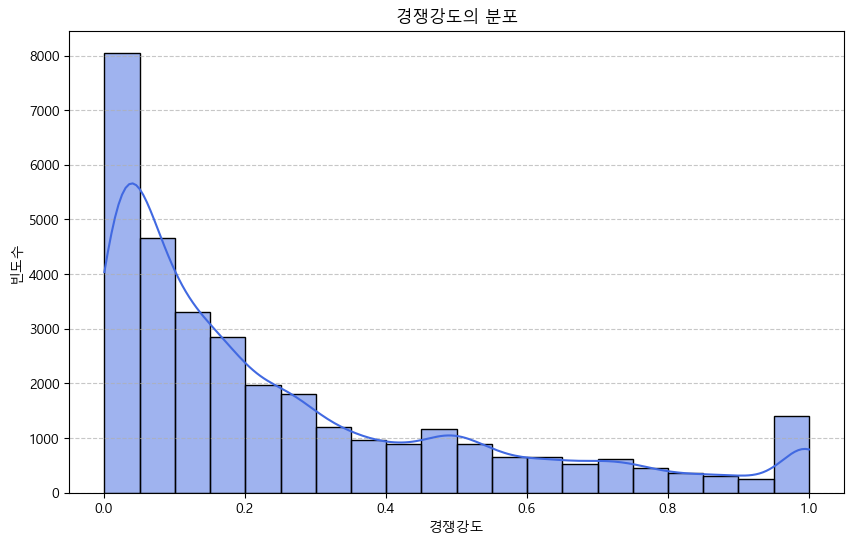

In [6]:
# 경쟁강도 분포 시각적으로 확인
plt.figure(figsize=(10, 6))
sns.histplot(data_label["경쟁강도"], bins=20, kde=True, color="royalblue")
plt.xlabel("경쟁강도")
plt.ylabel("빈도수")
plt.title("경쟁강도의 분포")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [7]:
# 포화도 기준 정하기 
data_label['경쟁강도'].describe()

mean_value = data_label["경쟁강도"].mean()
high_competition_count = (data_label["경쟁강도"] > mean_value).sum()
low_competition_count = (data_label["경쟁강도"] <= mean_value).sum()
print(f"경쟁강도가 평균보다 큰 행의 개수: {high_competition_count}")
print(f"경쟁강도가 평균보다 작은 행의 개수: {low_competition_count}")

경쟁강도가 평균보다 큰 행의 개수: 11689
경쟁강도가 평균보다 작은 행의 개수: 21321


In [8]:
# 기준에 따라 라벨 붙이기.
data_label['포화상태'] = data_label['경쟁강도'].apply(lambda x:'포화' if x > mean_value else '여유')

# 중복되는 데이터 drop 
data_label.drop_duplicates(inplace=True)

# 데이터 확인
data_label

,기준_년분기_코드,상권_코드_명,행정동_코드_명,자치구_코드_명,유사_업종_점포_수,행정동 내 점포수,경쟁강도,포화상태
0,20191,4.19민주묘지역 2번,우이동,강북구,34,282,0.120567,여유
1,20191,63빌딩,여의동,영등포구,70,2909,0.024063,여유
2,20191,DMC(디지털미디어시티),상암동,마포구,600,945,0.634921,포화
3,20191,GS강동자이아파트,길동,강동구,101,1698,0.059482,여유
4,20191,G타워,구로3동,구로구,26,2287,0.011369,여유
...,...,...,...,...,...,...,...,...
33005,20242,효창동주민센터,효창동,용산구,29,102,0.284314,포화
33006,20242,후암동주민센터,후암동,용산구,236,390,0.605128,포화
33007,20242,후암시장,후암동,용산구,57,390,0.146154,여유
33008,20242,휘문고교사거리,대치2동,강남구,80,1058,0.075614,여유


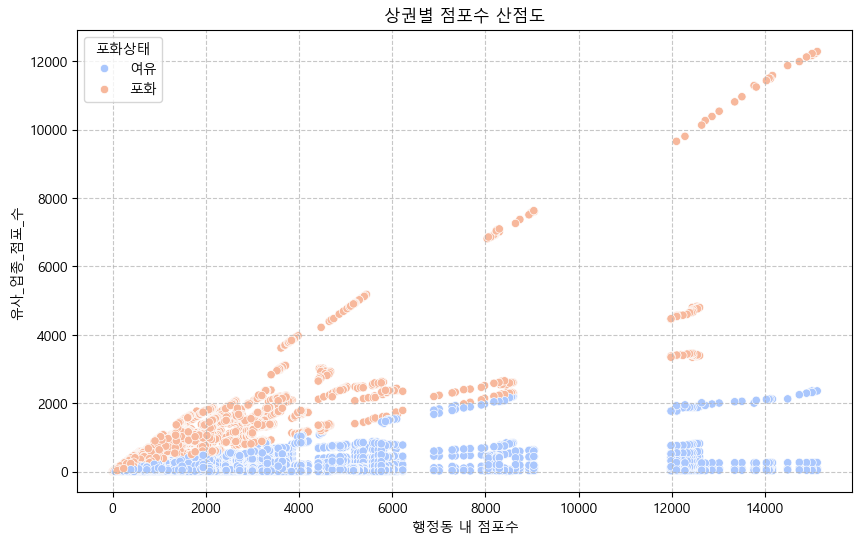

In [9]:
# 라벨링에 따라 점포수 분포 어떻게 되는지, 산점도로 확인. 
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=data_label, x="행정동 내 점포수", y="유사_업종_점포_수", hue="포화상태", palette="coolwarm")
plt.xlabel("행정동 내 점포수")
plt.ylabel("유사_업종_점포_수")
plt.title("상권별 점포수 산점도")
plt.legend(title="포화상태")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## 가설 1 행정동 평균 점포수보다 점포수가 많으면, 해당 상권은 포화했을 것이다. 

### 데이터 준비 

In [99]:
data_hypo1 = data_label.copy()

In [100]:
# 기준_년분기_코드, 행정동 기준으로 점포수 평균 계산
avg_store_count = data_hypo1.groupby(["기준_년분기_코드", "행정동_코드_명"])['유사_업종_점포_수'].mean().reset_index()
avg_store_count.rename(columns = {'유사_업종_점포_수':'행정동 평균 점포수'}, inplace=True)
avg_store_count

# 라벨 데이터에 merge 
data_hypo1 = pd.merge(data_hypo1, avg_store_count, on=["기준_년분기_코드", "행정동_코드_명"], how='left')

# 평균 이상 / 이하 라벨링
data_hypo1['가설1_x'] = data_hypo1.apply(lambda row: '평균 이상' if row['유사_업종_점포_수'] > row['행정동 평균 점포수'] else '평균 이하', axis=1)

# 데이터 확인
data_hypo1

,기준_년분기_코드,상권_코드_명,행정동_코드_명,자치구_코드_명,유사_업종_점포_수,행정동 내 점포수,경쟁강도,포화상태,행정동 평균 점포수,가설1_x
0,20191,4.19민주묘지역 2번,우이동,강북구,34,282,0.120567,여유,47.000000,평균 이하
1,20191,63빌딩,여의동,영등포구,70,2909,0.024063,여유,969.666667,평균 이하
2,20191,DMC(디지털미디어시티),상암동,마포구,600,945,0.634921,포화,472.500000,평균 이상
3,20191,GS강동자이아파트,길동,강동구,101,1698,0.059482,여유,212.250000,평균 이하
4,20191,G타워,구로3동,구로구,26,2287,0.011369,여유,571.750000,평균 이하
...,...,...,...,...,...,...,...,...,...,...
33005,20242,효창동주민센터,효창동,용산구,29,102,0.284314,포화,51.000000,평균 이하
33006,20242,후암동주민센터,후암동,용산구,236,390,0.605128,포화,97.500000,평균 이상
33007,20242,후암시장,후암동,용산구,57,390,0.146154,여유,97.500000,평균 이하
33008,20242,휘문고교사거리,대치2동,강남구,80,1058,0.075614,여유,352.666667,평균 이하


### 시각화 

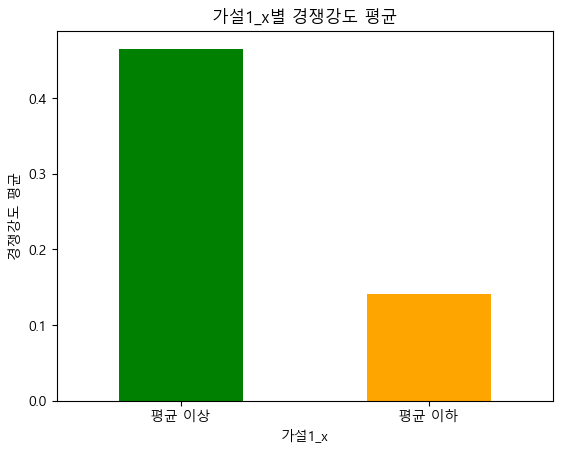

In [101]:
# '상권성장상태' 고유값별로 '총_유동인구_수_증감률' 컬럼의 평균 계산
average_by_many_state = data_hypo1.groupby('가설1_x')['경쟁강도'].mean()

# 막대그래프 그리기
average_by_many_state.plot(kind='bar', color=['green', 'orange', 'red'])

# 그래프 제목과 레이블 추가
plt.title('가설1_x별 경쟁강도 평균')
plt.xticks(rotation=0)
plt.xlabel('가설1_x')
plt.ylabel('경쟁강도 평균')

# 그래프 출력
plt.show()


### 통계분석

In [102]:
# 각 그룹별 총유동인구수증감률 추출
many = data_hypo1[data_hypo1['가설1_x'] == '평균 이상']['경쟁강도']
less = data_hypo1[data_hypo1['가설1_x'] == '평균 이하']['경쟁강도']

# Shapiro-Wilk 정규성 검정
many_normality = stats.shapiro(many)
less_normality = stats.shapiro(less)

# 결과 출력
print(f"many - p-value: {many_normality.pvalue}")
print(f"less - p-value: {less_normality.pvalue}")

# 정규성 검사 해석
if many_normality.pvalue < 0.05:
    print("성장 상권 데이터는 정규분포를 따르지 않습니다.")
else:
    print("성장 상권 데이터는 정규분포를 따릅니다.")

if less_normality.pvalue < 0.05:
    print("정체 상권 데이터는 정규분포를 따르지 않습니다.")
else:
    print("정체 상권 데이터는 정규분포를 따릅니다.")

many - p-value: 1.1388388232760317e-50
less - p-value: 2.4390269143307505e-114
성장 상권 데이터는 정규분포를 따르지 않습니다.
정체 상권 데이터는 정규분포를 따르지 않습니다.


c:\Users\dlwlg\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12375.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\dlwlg\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 20635.
  res = hypotest_fun_out(*samples, **kwds)


In [103]:
# Mann-Whitney U 검정 실행(평균 이상/이하 vs 경쟁강도)
u_stat, p_value = stats.mannwhitneyu(many, less, alternative='two-sided')

# Kruskal-Wallis 결과 출력
print(f"Mann-Whitney U 검정 결과: U-Statistic={u_stat}, p-value={p_value}")

Mann-Whitney U 검정 결과: U-Statistic=232561027.5, p-value=0.0


In [104]:
# Fisher의 정확 검정 (평균 이상/이하 vs 포화/여유)
# 분할표 (Contingency Table) 생성
contingency_table = pd.crosstab(data_hypo1['가설1_x'], data_hypo1['포화상태'])

# Fisher의 정확 검정 수행
oddsratio, p_value = stats.fisher_exact(contingency_table)

print(f"Fisher의 정확 검정 결과: Odds Ratio={oddsratio}, p-value={p_value}")

Fisher의 정확 검정 결과: Odds Ratio=0.03341096927829647, p-value=0.0


In [105]:
# 피어슨 상관계수 계산
corr_coeff, p_value = stats.pearsonr(data_hypo1['유사_업종_점포_수'], data_hypo1['경쟁강도'])

print(f"피어슨 상관분석 결과: 상관계수={corr_coeff}, p-value={p_value}")

피어슨 상관분석 결과: 상관계수=0.31338445078557825, p-value=0.0


## 가설 2 유동인구 대비 매출금액이 적은 상권은 포화 상태일 것이다. 

### 데이터 준비

In [29]:
data_hypo2 = data_label.copy()

In [30]:
# 상권 단위로 매출금액 sum + 유동인구 칼럼 붙이기
data_sale = data.groupby(['기준_년분기_코드','상권_코드_명'])['당월_매출_금액'].sum().reset_index()

data_hypo2 = pd.merge(data_hypo2, data_sale, on=['기준_년분기_코드','상권_코드_명'], how='left')
data_hypo2 = pd.merge(data_hypo2, data[['기준_년분기_코드','상권_코드_명','총_유동인구_수']], on=['기준_년분기_코드','상권_코드_명'], how='left')

# 중복되는 데이터 drop 
data_hypo2.drop_duplicates(inplace=True)

# 데이터 확인
data_hypo2.reset_index(inplace=True)
data_hypo2

,index,기준_년분기_코드,상권_코드_명,행정동_코드_명,자치구_코드_명,유사_업종_점포_수,행정동 내 점포수,경쟁강도,포화상태,당월_매출_금액,총_유동인구_수
0,0,20191,4.19민주묘지역 2번,우이동,강북구,34,282,0.120567,여유,2.712070e+08,522050
1,6,20191,63빌딩,여의동,영등포구,70,2909,0.024063,여유,1.993332e+08,57752
2,13,20191,DMC(디지털미디어시티),상암동,마포구,600,945,0.634921,포화,3.050783e+09,519877
3,42,20191,GS강동자이아파트,길동,강동구,101,1698,0.059482,여유,5.969977e+08,1049177
4,59,20191,G타워,구로3동,구로구,26,2287,0.011369,여유,2.236545e+08,351183
...,...,...,...,...,...,...,...,...,...,...,...
33005,445516,20242,효창동주민센터,효창동,용산구,29,102,0.284314,포화,2.075966e+08,1256249
33006,445522,20242,후암동주민센터,후암동,용산구,236,390,0.605128,포화,7.310171e+08,2083218
33007,445543,20242,후암시장,후암동,용산구,57,390,0.146154,여유,8.607352e+08,177952
33008,445556,20242,휘문고교사거리,대치2동,강남구,80,1058,0.075614,여유,8.225593e+09,336751


In [31]:
# 이상치를 조정할 칼럼 목록
cols = ['유사_업종_점포_수','총_유동인구_수','당월_매출_금액']

# 95번째 백분위수 기준으로 이상치 상한선 맞추기
for col in cols:
    upper_bound = data_hypo2[col].quantile(0.99)  # 95% 백분위수 계산
    data_hypo2[col] = np.where(data_hypo2[col] > upper_bound, upper_bound, data_hypo2[col])  # 초과값을 상한선으로 변경

In [32]:
# 유동인구 / 매출금액 칼럼 만들기. 
data_hypo2['가설2_x'] = data_hypo2['당월_매출_금액'] / data_hypo2['총_유동인구_수']

### 시각화 

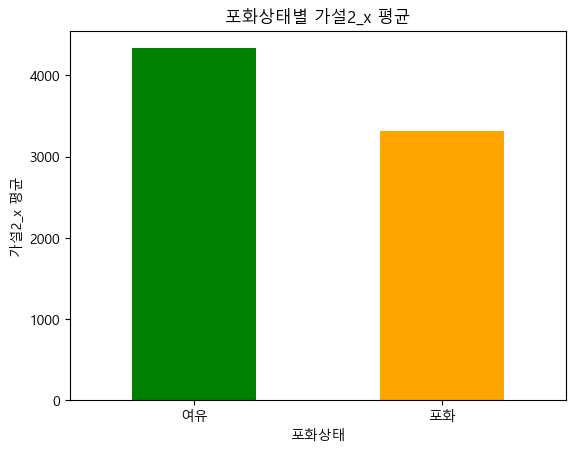

In [33]:
# '상권성장상태' 고유값별로 '총_유동인구_수_증감률' 컬럼의 평균 계산
average_by_many_state = data_hypo2.groupby('포화상태')['가설2_x'].mean()

# 막대그래프 그리기
average_by_many_state.plot(kind='bar', color=['green', 'orange', 'red'])

# 그래프 제목과 레이블 추가
plt.title('포화상태별 가설2_x 평균')
plt.xticks(rotation=0)
plt.xlabel('포화상태')
plt.ylabel('가설2_x 평균')

# 그래프 출력
plt.show()

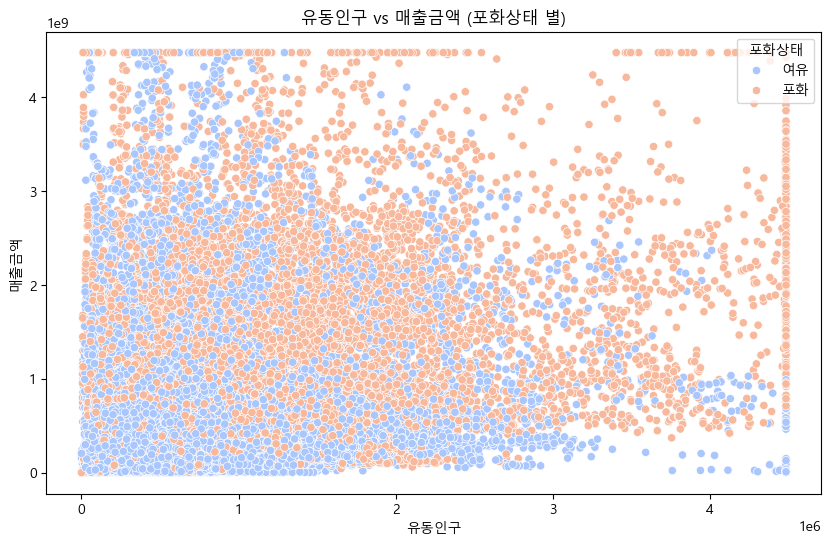

In [34]:
# 포화상태에 따라 색상 다르게 표시
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_hypo2, x='총_유동인구_수', y='당월_매출_금액', hue='포화상태', palette='coolwarm')
plt.title('유동인구 vs 매출금액 (포화상태 별)')
plt.xlabel('유동인구')
plt.ylabel('매출금액')
plt.legend(title='포화상태')
plt.show()

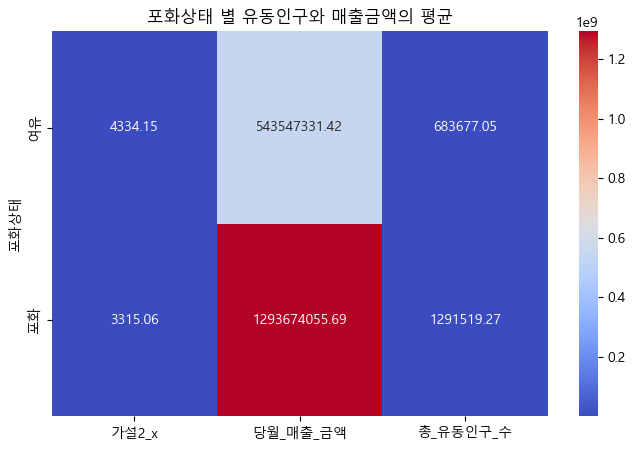

In [43]:
# 포화상태 별 유동인구와 매출금액의 평균 계산
pivot_table = data_hypo2.pivot_table(values=['총_유동인구_수', '당월_매출_금액','가설2_x'], index='포화상태', aggfunc='mean')

# 히트맵
plt.figure(figsize=(8, 5))
sns.heatmap(pivot_table, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('포화상태 별 유동인구와 매출금액의 평균')
plt.show()

### 통계분석

In [40]:
# 각 그룹별 총유동인구수증감률 추출
many = data_hypo2[data_hypo2['포화상태'] == '포화']['가설2_x']
less = data_hypo2[data_hypo2['포화상태'] == '여유']['가설2_x']

# Shapiro-Wilk 정규성 검정
many_normality = stats.shapiro(many)
less_normality = stats.shapiro(less)

# 결과 출력
print(f"many - p-value: {many_normality.pvalue}")
print(f"less - p-value: {less_normality.pvalue}")

# 정규성 검사 해석
if many_normality.pvalue < 0.05:
    print("포화 데이터는 정규분포를 따르지 않습니다.")
else:
    print("포화 데이터는 정규분포를 따릅니다.")

if less_normality.pvalue < 0.05:
    print("여유 데이터는 정규분포를 따르지 않습니다.")
else:
    print("여유 데이터는 정규분포를 따릅니다.")

many - p-value: 1.1281005300435091e-116
less - p-value: 9.580992359781916e-138
포화 데이터는 정규분포를 따르지 않습니다.
여유 데이터는 정규분포를 따르지 않습니다.


c:\Users\dlwlg\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11689.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\dlwlg\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 21321.
  res = hypotest_fun_out(*samples, **kwds)


In [41]:
# Mann-Whitney U 검정 실행(평균 이상/이하 vs 경쟁강도)
u_stat, p_value = stats.mannwhitneyu(many, less, alternative='two-sided')

# Kruskal-Wallis 결과 출력
print(f"Mann-Whitney U 검정 결과: U-Statistic={u_stat}, p-value={p_value}")

Mann-Whitney U 검정 결과: U-Statistic=153517666.0, p-value=4.911606659355795e-267


In [42]:
# 피어슨 상관계수 계산
corr_coeff, p_value = stats.pearsonr(data_hypo2['가설2_x'], data_hypo2['경쟁강도'])

print(f"피어슨 상관분석 결과: 상관계수={corr_coeff}, p-value={p_value}")

피어슨 상관분석 결과: 상관계수=-0.0007978065124368103, p-value=0.8847541060233208


## 가설 3 상권 내에 업종이 다양하면, 포화 상태일 것이다. 

### 데이터 준비

In [68]:
data_hypo3 = data_label.copy()

In [69]:
# 상권 내 서비스 업종 종류 수 구하기
data['업종다양성'] = data.groupby(['기준_년분기_코드', '상권_코드_명'])['서비스_업종_코드_명'].transform('nunique')

In [70]:
# 상권 단위로 매출금액 sum + 유동인구 칼럼 붙이기
data_sale = data.groupby(['기준_년분기_코드','상권_코드_명'])['당월_매출_금액'].sum().reset_index()

data_hypo3 = pd.merge(data_hypo3, data_sale, on=['기준_년분기_코드','상권_코드_명'], how='left')
data_hypo3 = pd.merge(data_hypo3, data[['기준_년분기_코드','상권_코드_명','총_유동인구_수','업종다양성']], on=['기준_년분기_코드','상권_코드_명'], how='left')

# 중복되는 데이터 drop 
data_hypo3.drop_duplicates(inplace=True)

# 데이터 확인
data_hypo3.reset_index(inplace=True)
data_hypo3.drop(columns='index',inplace=True)
data_hypo3

,기준_년분기_코드,상권_코드_명,행정동_코드_명,자치구_코드_명,유사_업종_점포_수,행정동 내 점포수,경쟁강도,포화상태,당월_매출_금액,총_유동인구_수,업종다양성
0,20191,4.19민주묘지역 2번,우이동,강북구,34,282,0.120567,여유,2.712070e+08,522050,6
1,20191,63빌딩,여의동,영등포구,70,2909,0.024063,여유,1.993332e+08,57752,7
2,20191,DMC(디지털미디어시티),상암동,마포구,600,945,0.634921,포화,3.050783e+09,519877,29
3,20191,GS강동자이아파트,길동,강동구,101,1698,0.059482,여유,5.969977e+08,1049177,17
4,20191,G타워,구로3동,구로구,26,2287,0.011369,여유,2.236545e+08,351183,4
...,...,...,...,...,...,...,...,...,...,...,...
33005,20242,효창동주민센터,효창동,용산구,29,102,0.284314,포화,2.075966e+08,1256249,6
33006,20242,후암동주민센터,후암동,용산구,236,390,0.605128,포화,7.310171e+08,2083218,21
33007,20242,후암시장,후암동,용산구,57,390,0.146154,여유,8.607352e+08,177952,13
33008,20242,휘문고교사거리,대치2동,강남구,80,1058,0.075614,여유,8.225593e+09,336751,13


In [73]:
# 이상치를 조정할 칼럼 목록
cols = ['유사_업종_점포_수','총_유동인구_수','당월_매출_금액']

# 95번째 백분위수 기준으로 이상치 상한선 맞추기
for col in cols:
    upper_bound = data_hypo3[col].quantile(0.99)  # 95% 백분위수 계산
    data_hypo3[col] = np.where(data_hypo3[col] > upper_bound, upper_bound, data_hypo3[col])  # 초과값을 상한선으로 변경

In [79]:
# 점포 수 / 업종다양성
data_hypo3['가설3_x'] = data_hypo3['유사_업종_점포_수'] / data_hypo3['업종다양성']

### 시각화 

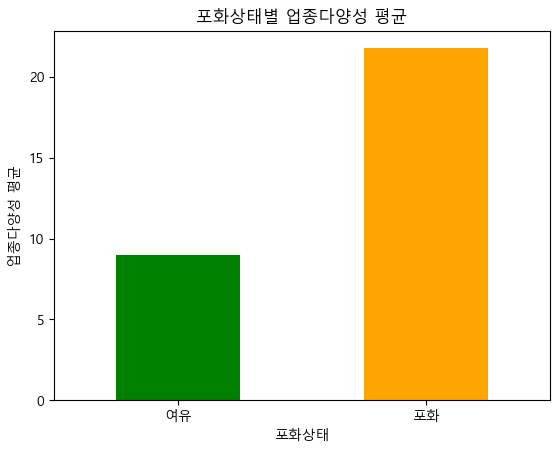

In [91]:
# '상권성장상태' 고유값별로 '총_유동인구_수_증감률' 컬럼의 평균 계산
average_by_many_state = data_hypo3.groupby('포화상태')['업종다양성'].mean()

# 막대그래프 그리기
average_by_many_state.plot(kind='bar', color=['green', 'orange', 'red'])

# 그래프 제목과 레이블 추가
plt.title('포화상태별 업종다양성 평균')
plt.xticks(rotation=0)
plt.xlabel('포화상태')
plt.ylabel('업종다양성 평균')

# 그래프 출력
plt.show()

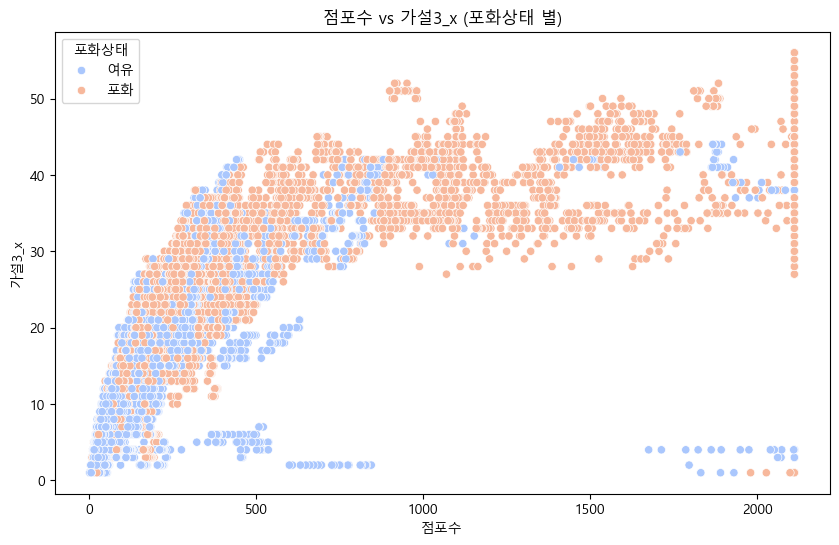

In [96]:
# 포화상태에 따라 색상 다르게 표시
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_hypo3, x='유사_업종_점포_수', y='업종다양성', hue='포화상태', palette='coolwarm')
plt.title('점포수 vs 가설3_x (포화상태 별)')
plt.xlabel('점포수')
plt.ylabel('가설3_x')
plt.legend(title='포화상태')
plt.show()

### 통계분석

In [97]:
# 각 그룹별 총유동인구수증감률 추출
many = data_hypo3[data_hypo3['포화상태'] == '포화']['업종다양성']
less = data_hypo3[data_hypo3['포화상태'] == '여유']['업종다양성']

# Shapiro-Wilk 정규성 검정
many_normality = stats.shapiro(many)
less_normality = stats.shapiro(less)

# 결과 출력
print(f"many - p-value: {many_normality.pvalue}")
print(f"less - p-value: {less_normality.pvalue}")

# 정규성 검사 해석
if many_normality.pvalue < 0.05:
    print("포화 데이터는 정규분포를 따르지 않습니다.")
else:
    print("포화 데이터는 정규분포를 따릅니다.")

if less_normality.pvalue < 0.05:
    print("여유 데이터는 정규분포를 따르지 않습니다.")
else:
    print("여유 데이터는 정규분포를 따릅니다.")

many - p-value: 3.829008403373738e-42
less - p-value: 1.0579003542927134e-87
포화 데이터는 정규분포를 따르지 않습니다.
여유 데이터는 정규분포를 따르지 않습니다.


c:\Users\dlwlg\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11689.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\dlwlg\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 21321.
  res = hypotest_fun_out(*samples, **kwds)


In [98]:
# Mann-Whitney U 검정 실행(평균 이상/이하 vs 경쟁강도)
u_stat, p_value = stats.mannwhitneyu(many, less, alternative='two-sided')

# Kruskal-Wallis 결과 출력
print(f"Mann-Whitney U 검정 결과: U-Statistic={u_stat}, p-value={p_value}")

Mann-Whitney U 검정 결과: U-Statistic=207769452.0, p-value=0.0


In [99]:
# 피어슨 상관계수 계산
corr_coeff, p_value = stats.pearsonr(data_hypo3['업종다양성'], data_hypo3['경쟁강도'])

print(f"피어슨 상관분석 결과: 상관계수={corr_coeff}, p-value={p_value}")

피어슨 상관분석 결과: 상관계수=0.5554433415762733, p-value=0.0


## 가설 4 전분기 대비 점포수가 늘어난 경우가 잦다면, 포화 상태일 것이다.

### 데이터 준비

In [139]:
data_hypo4 = data_label.copy()

In [140]:
# 기준년분기&상권 기준 정렬
data_hypo4 = data_hypo4.sort_values(['상권_코드_명','기준_년분기_코드'])

# 기준년분기코드 기준으로 저눈기 대비 점포수가 증가한 경우에 1/0 부여하기
data_hypo4['전분기_점포수'] = data_hypo4.groupby('상권_코드_명')['유사_업종_점포_수'].shift(1) 
data_hypo4['점포수 증가'] = (data_hypo4['유사_업종_점포_수'] > data_hypo4['전분기_점포수']).astype(int)

# 20242 까지의 점수 합산
data_hypo4['개업 점수'] = data_hypo4.groupby('상권_코드_명')['점포수 증가'].cumsum()

# 데이터 확인
data_hypo4.reset_index(inplace=True)
data_hypo4.drop(columns='index',inplace=True)
data_hypo4

,기준_년분기_코드,상권_코드_명,행정동_코드_명,자치구_코드_명,유사_업종_점포_수,행정동 내 점포수,경쟁강도,포화상태,전분기_점포수,점포수 증가,개업 점수
0,20191,4.19민주묘지역 2번,우이동,강북구,34,282,0.120567,여유,NaN,0,0
1,20192,4.19민주묘지역 2번,우이동,강북구,35,283,0.123675,여유,34.0,1,1
2,20193,4.19민주묘지역 2번,우이동,강북구,31,272,0.113971,여유,35.0,0,1
3,20194,4.19민주묘지역 2번,우이동,강북구,33,258,0.127907,여유,31.0,1,2
4,20201,4.19민주묘지역 2번,우이동,강북구,38,276,0.137681,여유,33.0,1,3
...,...,...,...,...,...,...,...,...,...,...,...
33005,20232,흑리단길,흑석동,동작구,89,239,0.372385,포화,87.0,1,5
33006,20233,흑리단길,흑석동,동작구,85,232,0.366379,포화,89.0,0,5
33007,20234,흑리단길,흑석동,동작구,88,231,0.380952,포화,85.0,1,6
33008,20241,흑리단길,흑석동,동작구,90,235,0.382979,포화,88.0,1,7


### 시각화 

Text(0.5, 1.0, '포화상태에 따른 개업 점수 밀도')

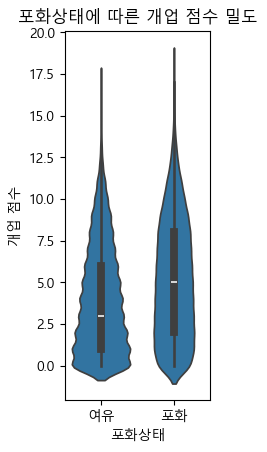

In [141]:
plt.subplot(1, 3, 1)
sns.violinplot(data=data_hypo4, x='포화상태', y='개업 점수')
plt.title('포화상태에 따른 개업 점수 밀도')

### 통계분석

In [142]:
# 각 그룹별 총유동인구수증감률 추출
many = data_hypo4[data_hypo4['포화상태'] == '포화']['개업 점수']
less = data_hypo4[data_hypo4['포화상태'] == '여유']['개업 점수']

# Shapiro-Wilk 정규성 검정
many_normality = stats.shapiro(many)
less_normality = stats.shapiro(less)

# 결과 출력
print(f"many - p-value: {many_normality.pvalue}")
print(f"less - p-value: {less_normality.pvalue}")

# 정규성 검사 해석
if many_normality.pvalue < 0.05:
    print("포화 데이터는 정규분포를 따르지 않습니다.")
else:
    print("포화 데이터는 정규분포를 따릅니다.")

if less_normality.pvalue < 0.05:
    print("여유 데이터는 정규분포를 따르지 않습니다.")
else:
    print("여유 데이터는 정규분포를 따릅니다.")

many - p-value: 8.316314469927106e-49
less - p-value: 7.373956486867577e-70
포화 데이터는 정규분포를 따르지 않습니다.
여유 데이터는 정규분포를 따르지 않습니다.


c:\Users\dlwlg\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11689.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\dlwlg\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 21321.
  res = hypotest_fun_out(*samples, **kwds)


In [143]:
# Mann-Whitney U 검정 실행(평균 이상/이하 vs 경쟁강도)
u_stat, p_value = stats.mannwhitneyu(many, less, alternative='two-sided')

# Kruskal-Wallis 결과 출력
print(f"Mann-Whitney U 검정 결과: U-Statistic={u_stat}, p-value={p_value}")

Mann-Whitney U 검정 결과: U-Statistic=148474891.0, p-value=2.5493442523641933e-184


In [144]:
# 피어슨 상관계수 계산
corr_coeff, p_value = stats.pearsonr(data_hypo4['개업 점수'], data_hypo4['경쟁강도'])

print(f"피어슨 상관분석 결과: 상관계수={corr_coeff}, p-value={p_value}")

피어슨 상관분석 결과: 상관계수=0.17040255398432919, p-value=1.597833093147266e-213


## 가설 5 유동인구 대비 점포가 많은 상권은, 포화 상태일 것이다. 

### 데이터 준비

In [156]:
data_hypo5 = data_label.copy()

In [157]:
# 상권 단위로 유동인구 칼럼 붙이기
data_hypo5 = pd.merge(data_hypo5, data[['기준_년분기_코드','상권_코드_명','총_유동인구_수']], on=['기준_년분기_코드','상권_코드_명'], how='left')

# 중복되는 데이터 drop 
data_hypo5.drop_duplicates(inplace=True)

# 데이터 확인
data_hypo5 = data_hypo5.reset_index(drop=True)
data_hypo5

,기준_년분기_코드,상권_코드_명,행정동_코드_명,자치구_코드_명,유사_업종_점포_수,행정동 내 점포수,경쟁강도,포화상태,총_유동인구_수
0,20191,4.19민주묘지역 2번,우이동,강북구,34,282,0.120567,여유,522050
1,20191,63빌딩,여의동,영등포구,70,2909,0.024063,여유,57752
2,20191,DMC(디지털미디어시티),상암동,마포구,600,945,0.634921,포화,519877
3,20191,GS강동자이아파트,길동,강동구,101,1698,0.059482,여유,1049177
4,20191,G타워,구로3동,구로구,26,2287,0.011369,여유,351183
...,...,...,...,...,...,...,...,...,...
33005,20242,효창동주민센터,효창동,용산구,29,102,0.284314,포화,1256249
33006,20242,후암동주민센터,후암동,용산구,236,390,0.605128,포화,2083218
33007,20242,후암시장,후암동,용산구,57,390,0.146154,여유,177952
33008,20242,휘문고교사거리,대치2동,강남구,80,1058,0.075614,여유,336751


In [158]:
# 유동인구 / 점포 수 
data_hypo5['가설5_x'] = data_hypo5['총_유동인구_수'] / data_hypo5['유사_업종_점포_수']

### 시각화 

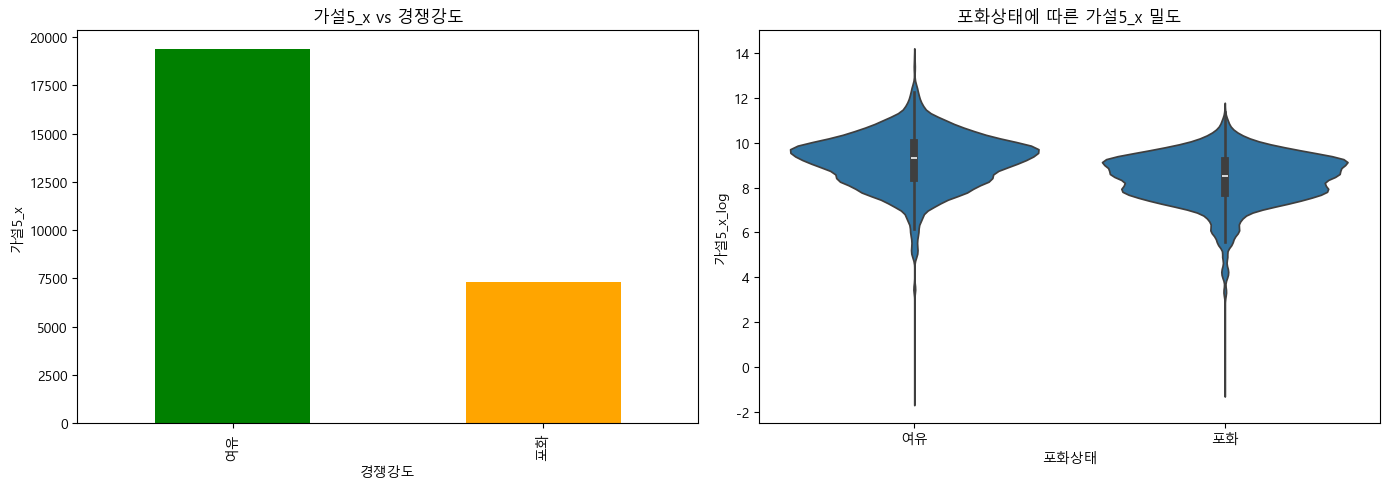

In [177]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 5))  # 전체 figure 크기 설정

# 1. 가설5_x vs 경쟁강도 산점도
plt.subplot(1, 2, 1)  # 1행 2열 중 첫 번째 그래프
# '상권성장상태' 고유값별로 '총_유동인구_수_증감률' 컬럼의 평균 계산
average_by_many_state = data_hypo5.groupby('포화상태')['가설5_x'].mean()

# 막대그래프 그리기
average_by_many_state.plot(kind='bar', color=['green', 'orange', 'red'])
plt.title('가설5_x vs 경쟁강도')
plt.xlabel('경쟁강도')
plt.ylabel('가설5_x')

# 2. 포화상태에 따른 가설5_x 밀도 (바이올린 플롯)
plt.subplot(1, 2, 2)  # 1행 2열 중 두 번째 그래프
sns.violinplot(data=data_hypo5, x='포화상태', y='가설5_x_log')
plt.title('포화상태에 따른 가설5_x 밀도')

plt.tight_layout()  # 그래프 간격 자동 조정
plt.show()


### 통계분석

In [166]:
# 각 그룹별 총유동인구수증감률 추출
many = data_hypo5[data_hypo5['포화상태'] == '포화']['가설5_x']
less = data_hypo5[data_hypo5['포화상태'] == '여유']['가설5_x']

# Shapiro-Wilk 정규성 검정
many_normality = stats.shapiro(many)
less_normality = stats.shapiro(less)

# 결과 출력
print(f"many - p-value: {many_normality.pvalue}")
print(f"less - p-value: {less_normality.pvalue}")

# 정규성 검사 해석
if many_normality.pvalue < 0.05:
    print("포화 데이터는 정규분포를 따르지 않습니다.")
else:
    print("포화 데이터는 정규분포를 따릅니다.")

if less_normality.pvalue < 0.05:
    print("여유 데이터는 정규분포를 따르지 않습니다.")
else:
    print("여유 데이터는 정규분포를 따릅니다.")

many - p-value: 3.35952488953496e-85
less - p-value: 3.518374530772422e-124
포화 데이터는 정규분포를 따르지 않습니다.
여유 데이터는 정규분포를 따르지 않습니다.


c:\Users\dlwlg\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11689.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\dlwlg\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 21321.
  res = hypotest_fun_out(*samples, **kwds)


In [167]:
# Mann-Whitney U 검정 실행(평균 이상/이하 vs 경쟁강도)
u_stat, p_value = stats.mannwhitneyu(many, less, alternative='two-sided')

# Kruskal-Wallis 결과 출력
print(f"Mann-Whitney U 검정 결과: U-Statistic={u_stat}, p-value={p_value}")

Mann-Whitney U 검정 결과: U-Statistic=75081659.0, p-value=0.0


In [168]:
# 피어슨 상관계수 계산
corr_coeff, p_value = stats.pearsonr(data_hypo5['가설5_x'], data_hypo5['경쟁강도'])

print(f"피어슨 상관분석 결과: 상관계수={corr_coeff}, p-value={p_value}")

피어슨 상관분석 결과: 상관계수=-0.20455594627719434, p-value=9.14990622757431e-309


## 경쟁강도와 상관관계 높은 것 출력 

In [180]:
# merge
test = pd.merge(data_label[['기준_년분기_코드','상권_코드_명','경쟁강도']], data, on=['기준_년분기_코드','상권_코드_명'], how='right')

In [182]:
import seaborn as sns
import matplotlib.pyplot as plt

# 수치형 데이터만 선택
numeric_data = test.select_dtypes(include=['number'])

# 상관관계 행렬 계산
corr_matrix = numeric_data.corr()

# '경쟁강도'와 상관관계가 높은 상위 20개 변수 추출 (자기 자신은 제외)
top_20_corr = corr_matrix['경쟁강도'].drop('경쟁강도').abs().sort_values(ascending=False).head(187)

# # 히트맵 출력
# plt.figure(figsize=(10, 8))
# sns.heatmap(corr_matrix.loc[top_20_corr.index, top_20_corr.index], annot=True, cmap='coolwarm', fmt='.2f')
# plt.title('Top 20 Variables Correlated with 경쟁강도')
# plt.show()

print(top_20_corr)

업종다양성              0.500741
상권내세부서비스업종수        0.500741
약국_수               0.410997
시설수                0.391762
버스_정거장_수           0.389835
                     ...   
수요일_매출_금액_비율       0.000429
수요일_매출_건수_비율       0.000308
토요일_매출_건수_비율       0.000250
시간대_06~11_매출_금액    0.000002
철도_역_수                  NaN
Name: 경쟁강도, Length: 179, dtype: float64


In [184]:
top_20_corr.to_csv("C:/Users/dlwlg/Desktop/final/상권지수/상관계수.csv",encoding='cp949')